In [40]:
import time
import numpy as np
import pandas as pd
import os
import json
import re
from typing import Dict, Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

### Configuración común a los modelos:

In [16]:
# Configuración
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2 # Porcion del set train

N_TRIALS_XGB = 40
EARLY_STOP_ROUNDS = 200

### Primer modelo XGBoost --> Control: Sin VCR ni coordenadas

In [17]:
# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])
df_vcr_c['log_monto'].describe()

count    25211.000000
mean         8.395828
std          0.830310
min          5.950643
25%          7.740664
50%          8.242756
75%          8.984694
max         10.915088
Name: log_monto, dtype: float64

In [18]:
#Configuración específica del dataset para el modelo
df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)
df_base.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [19]:
# Split
DF = df_base
X = DF.drop(columns=["monto", "log_monto"]).copy()
y = DF["log_monto"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

Shapes -> train: (16134, 21), val: (4034, 21), test: (5043, 21)


In [20]:
# === Importar hiperparámetros ===
VERSION_TAG = "v1"  # <-- que coincida con el archivo exportado
hp_path = os.path.join("models_XGB", f"best_params_XGB_{VERSION_TAG}.json")

with open(hp_path, "r") as f:
    best_params_sklearn = json.load(f)

print("Hiperparámetros XGB cargados:")
for k, v in best_params_sklearn.items():
    print(f"  {k}: {v}")


Hiperparámetros XGB cargados:
  n_estimators: 2291
  learning_rate: 0.017150257367157886
  max_depth: 7
  min_child_weight: 6
  subsample: 0.6014398847131033
  colsample_bytree: 0.9880271934157469
  gamma: 0.12774747405271736
  reg_alpha: 0.032318743776449575
  reg_lambda: 9.59454591610047
  objective: reg:squarederror
  random_state: 42


In [26]:
# Construcción del modelo (usa los HP importados)
model = XGBRegressor(
    **best_params_sklearn,
    eval_metric="rmse",
    device="cuda",
)

start = time.perf_counter()
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # registra train y val
    verbose=False,
)
elapsed = time.perf_counter() - start

print(f"Tiempo entrenamiento: {elapsed:.2f} s | n_estimators={best_params_sklearn['n_estimators']}")

# Historial para el gráfico (RMSE en LOG por iteración)
results = model.evals_result()  # dict
rmse_log_train = results["validation_0"]["rmse"]
rmse_log_val   = results["validation_1"]["rmse"]


Tiempo entrenamiento: 16.52 s | n_estimators=2291


In [27]:
curves_df = pd.DataFrame({
    "rmse_log_train": rmse_log_train,
    "rmse_log_val": rmse_log_val,
})
curves_df.to_csv(os.path.join("models_XGB", f"train_curves_XGB_{VERSION_TAG}.csv"), index=False)

# Guardar modelo (formato nativo de XGBoost, estable entre versiones)
model.save_model(os.path.join("models_XGB", f"XGB_model_{VERSION_TAG}.json"))

# Guardar nombres de features (orden de entrenamiento)
feature_names = list(X_train.columns) if hasattr(X_train, "columns") else list(DF.drop(columns=["monto","log_monto"]).columns)
with open(os.path.join("models_XGB", f"feature_names_XGB_{VERSION_TAG}.json"), "w") as f:
    json.dump(feature_names, f, indent=2)

print(f"Guardados -> modelo, curvas y features en models_XGB/ (tag={VERSION_TAG})")

Guardados -> modelo, curvas y features en models_XGB/ (tag=v1)


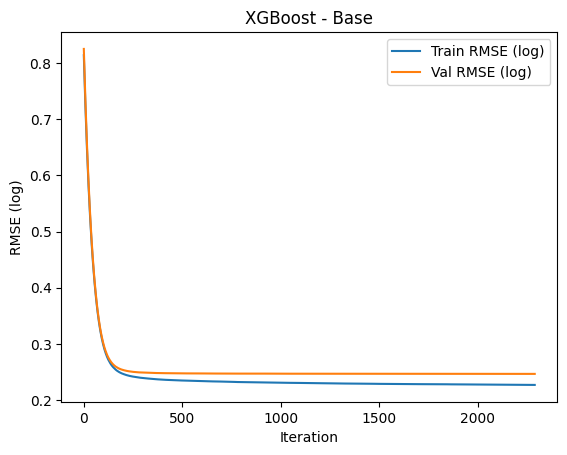

In [28]:
plt.figure()
plt.plot(rmse_log_train, label="Train RMSE (log)")
plt.plot(rmse_log_val, label="Val RMSE (log)")
plt.xlabel("Iteration"); plt.ylabel("RMSE (log)")
plt.title("XGBoost - Base")
plt.legend(); plt.show()

In [29]:
# --- Predicciones en LOG ---
y_pred_train_log = model.predict(X_train)
y_pred_val_log   = model.predict(X_val)
y_pred_test_log  = model.predict(X_test)

# --- Métricas en LOG ---
def rmse_log(y_true_log, y_pred_log):
    return float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))

r2_log_train   = r2_score(y_train, y_pred_train_log)
r2_log_val     = r2_score(y_val,   y_pred_val_log)
r2_log_test    = r2_score(y_test,  y_pred_test_log)

rmse_log_train = rmse_log(y_train, y_pred_train_log)
rmse_log_val   = rmse_log(y_val,   y_pred_val_log)
rmse_log_test  = rmse_log(y_test,  y_pred_test_log)

mae_log_train  = mean_absolute_error(y_train, y_pred_train_log)
mae_log_val    = mean_absolute_error(y_val,   y_pred_val_log)
mae_log_test   = mean_absolute_error(y_test,  y_pred_test_log)

# --- Métricas en UF (precio) ---
y_true_train_price = DF.loc[X_train.index, "monto"].to_numpy(dtype=float)
y_true_val_price   = DF.loc[X_val.index,   "monto"].to_numpy(dtype=float)
y_true_test_price  = DF.loc[X_test.index,  "monto"].to_numpy(dtype=float)

y_pred_train_price = np.exp(y_pred_train_log)
y_pred_val_price   = np.exp(y_pred_val_log)
y_pred_test_price  = np.exp(y_pred_test_log)

rmse_train = root_mean_squared_error(y_true_train_price, y_pred_train_price)
rmse_val   = root_mean_squared_error(y_true_val_price,   y_pred_val_price)
rmse_test  = root_mean_squared_error(y_true_test_price,  y_pred_test_price)

mae_train  = mean_absolute_error(y_true_train_price, y_pred_train_price)
mae_val    = mean_absolute_error(y_true_val_price,   y_pred_val_price)
mae_test   = mean_absolute_error(y_true_test_price,  y_pred_test_price)

mape_train = np.mean(np.abs((y_true_train_price - y_pred_train_price) / np.clip(y_true_train_price, 1e-9, None))) * 100
mape_val   = np.mean(np.abs((y_true_val_price   - y_pred_val_price)   / np.clip(y_true_val_price,   1e-9, None))) * 100
mape_test  = np.mean(np.abs((y_true_test_price  - y_pred_test_price)  / np.clip(y_true_test_price,  1e-9, None))) * 100

print("=== XGBoost control ===")
print(">> LOG space")
print(f"Train: R^2={r2_log_train:.4f} | RMSE_log={rmse_log_train:.4f} | MAE_log={mae_log_train:.4f}")
print(f"Val  : R^2={r2_log_val:.4f}   | RMSE_log={rmse_log_val:.4f}   | MAE_log={mae_log_val:.4f}")
print(f"Test : R^2={r2_log_test:.4f}  | RMSE_log={rmse_log_test:.4f}  | MAE_log={mae_log_test:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={rmse_train:,.2f} | MAE={mae_train:,.2f} | MAPE={mape_train:.2f}%")
print(f"Val  : RMSE={rmse_val:,.2f}   | MAE={mae_val:,.2f}   | MAPE={mape_val:.2f}%")
print(f"Test : RMSE={rmse_test:,.2f}  | MAE={mae_test:,.2f}  | MAPE={mape_test:.2f}%")



# %% Importancias (gain)
booster = model.get_booster()
score = booster.get_score(importance_type="gain")
if score:
    imp = (
        pd.Series(score)
        .rename("gain")
        .sort_values(ascending=False)
        .to_frame()
        )
print("\nTop 20 features por gain:")
print(imp.head(20).to_string())

=== XGBoost control ===
>> LOG space
Train: R^2=0.9246 | RMSE_log=0.2268 | MAE_log=0.1688
Val  : R^2=0.9134   | RMSE_log=0.2465   | MAE_log=0.1834
Test : R^2=0.9127  | RMSE_log=0.2476  | MAE_log=0.1851
>> UF space (precio)
Train: RMSE=1,758.74 | MAE=968.72 | MAPE=17.41%
Val  : RMSE=2,028.34   | MAE=1,105.52   | MAPE=19.14%
Test : RMSE=1,931.58  | MAE=1,068.16  | MAPE=19.25%

Top 20 features por gain:
                           gain
superficie_t          19.895973
banos                  2.667831
estacionamiento        1.652277
bodegas                1.101921
dormitorios            1.050108
terraza                0.566058
antiguedad             0.435443
banos_faltante         0.409869
antiguedad_faltante    0.309278
flag_Semipiso          0.292062
flag_Departamento      0.286085
Or_Faltante            0.284197
dormitorios_faltante   0.274552
Or_O                   0.243711
Or_E                   0.240251
Or_S                   0.236665
Or_N                   0.229483
flag_Premium        

### Segundo modelo XGBoost --> Sin VCR y con coordenadas

In [30]:
#Configuración específica del modelo
df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)
df_coord.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monto                 25211 non-null  int64  
 1   superficie_t          25211 non-null  float64
 2   dormitorios           25211 non-null  int64  
 3   dormitorios_faltante  25211 non-null  int64  
 4   banos                 25211 non-null  int64  
 5   banos_faltante        25211 non-null  int64  
 6   antiguedad            25211 non-null  int64  
 7   antiguedad_faltante   25211 non-null  int64  
 8   Or_N                  25211 non-null  int64  
 9   Or_S                  25211 non-null  int64  
 10  Or_E                  25211 non-null  int64  
 11  Or_O                  25211 non-null  int64  
 12  Or_Faltante           25211 non-null  int64  
 13  terraza               25211 non-null  float64
 14  estacionamiento       25211 non-null  int64  
 15  bodegas               25

In [31]:
# Split
DF = df_coord
X = DF.drop(columns=["monto", "log_monto"]).copy()
y = DF["log_monto"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

Shapes -> train: (16134, 23), val: (4034, 23), test: (5043, 23)


In [32]:
# === Importar hiperparámetros ===
VERSION_TAG = "v2"  # <-- que coincida con el archivo exportado
hp_path = os.path.join("models_XGB", f"best_params_XGB_{VERSION_TAG}.json")

with open(hp_path, "r") as f:
    best_params_sklearn = json.load(f)

print("Hiperparámetros XGB cargados:")
for k, v in best_params_sklearn.items():
    print(f"  {k}: {v}")


Hiperparámetros XGB cargados:
  n_estimators: 2434
  learning_rate: 0.01598029907089681
  max_depth: 6
  min_child_weight: 7
  subsample: 0.6258677398554287
  colsample_bytree: 0.9000140525013864
  gamma: 0.02216528188531427
  reg_alpha: 4.475293711821796e-07
  reg_lambda: 0.052106789670926024
  objective: reg:squarederror
  random_state: 42


In [ ]:
# Construcción del modelo 

model = XGBRegressor(
    **best_params_sklearn,
    eval_metric="rmse",
    device="cuda",
)

start = time.perf_counter()
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # registra train y val
    verbose=False,
)
elapsed = time.perf_counter() - start

best_iter = getattr(model, "best_iteration", None)
print(f"Tiempo entrenamiento: {elapsed:.2f} s | Best iter: {best_iter}")

# Historial para el gráfico (RMSE en LOG por iteración)
results = model.evals_result()  # dict
rmse_log_train = results["validation_0"]["rmse"]
rmse_log_val   = results["validation_1"]["rmse"]

Tiempo entrenamiento: 21.43 s | Best iter: 2270


In [35]:
curves_df = pd.DataFrame({
    "rmse_log_train": rmse_log_train,
    "rmse_log_val": rmse_log_val,
})
curves_df.to_csv(os.path.join("models_XGB", f"train_curves_XGB_{VERSION_TAG}.csv"), index=False)

# Guardar modelo (formato nativo de XGBoost, estable entre versiones)
model.save_model(os.path.join("models_XGB", f"XGB_model_{VERSION_TAG}.json"))

# Guardar nombres de features (orden de entrenamiento)
feature_names = list(X_train.columns) if hasattr(X_train, "columns") else list(DF.drop(columns=["monto","log_monto"]).columns)
with open(os.path.join("models_XGB", f"feature_names_XGB_{VERSION_TAG}.json"), "w") as f:
    json.dump(feature_names, f, indent=2)

print(f"Guardados -> modelo, curvas y features en models_XGB/ (tag={VERSION_TAG})")

Guardados -> modelo, curvas y features en models_XGB/ (tag=v2)


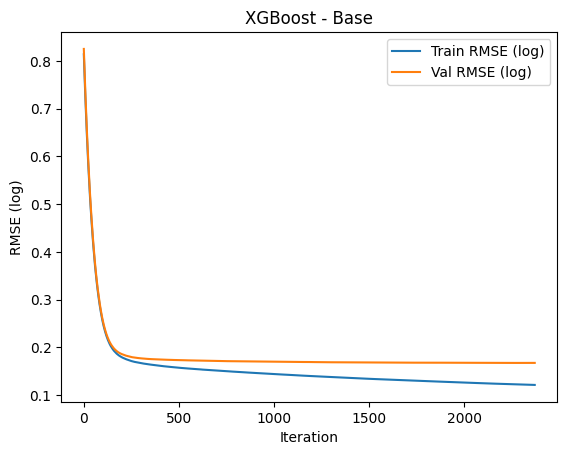

In [ ]:
plt.figure()
plt.plot(rmse_log_train, label="Train RMSE (log)")
plt.plot(rmse_log_val, label="Val RMSE (log)")
plt.xlabel("Iteration"); plt.ylabel("RMSE (log)")
plt.title("XGBoost - Coordenadas")
plt.legend(); plt.show()

In [37]:
# --- Predicciones en LOG ---
y_pred_train_log = model.predict(X_train)
y_pred_val_log   = model.predict(X_val)
y_pred_test_log  = model.predict(X_test)

# --- Métricas en LOG ---
def rmse_log(y_true_log, y_pred_log):
    return float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))

r2_log_train   = r2_score(y_train, y_pred_train_log)
r2_log_val     = r2_score(y_val,   y_pred_val_log)
r2_log_test    = r2_score(y_test,  y_pred_test_log)

rmse_log_train = rmse_log(y_train, y_pred_train_log)
rmse_log_val   = rmse_log(y_val,   y_pred_val_log)
rmse_log_test  = rmse_log(y_test,  y_pred_test_log)

mae_log_train  = mean_absolute_error(y_train, y_pred_train_log)
mae_log_val    = mean_absolute_error(y_val,   y_pred_val_log)
mae_log_test   = mean_absolute_error(y_test,  y_pred_test_log)

# --- Métricas en UF (precio) ---
y_true_train_price = DF.loc[X_train.index, "monto"].to_numpy(dtype=float)
y_true_val_price   = DF.loc[X_val.index,   "monto"].to_numpy(dtype=float)
y_true_test_price  = DF.loc[X_test.index,  "monto"].to_numpy(dtype=float)

y_pred_train_price = np.exp(y_pred_train_log)
y_pred_val_price   = np.exp(y_pred_val_log)
y_pred_test_price  = np.exp(y_pred_test_log)

rmse_train = root_mean_squared_error(y_true_train_price, y_pred_train_price)
rmse_val   = root_mean_squared_error(y_true_val_price,   y_pred_val_price)
rmse_test  = root_mean_squared_error(y_true_test_price,  y_pred_test_price)

mae_train  = mean_absolute_error(y_true_train_price, y_pred_train_price)
mae_val    = mean_absolute_error(y_true_val_price,   y_pred_val_price)
mae_test   = mean_absolute_error(y_true_test_price,  y_pred_test_price)

mape_train = np.mean(np.abs((y_true_train_price - y_pred_train_price) / np.clip(y_true_train_price, 1e-9, None))) * 100
mape_val   = np.mean(np.abs((y_true_val_price   - y_pred_val_price)   / np.clip(y_true_val_price,   1e-9, None))) * 100
mape_test  = np.mean(np.abs((y_true_test_price  - y_pred_test_price)  / np.clip(y_true_test_price,  1e-9, None))) * 100

print("=== XGBoost + latitud y longitud ===")
print(">> LOG space")
print(f"Train: R^2={r2_log_train:.4f} | RMSE_log={rmse_log_train:.4f} | MAE_log={mae_log_train:.4f}")
print(f"Val  : R^2={r2_log_val:.4f}   | RMSE_log={rmse_log_val:.4f}   | MAE_log={mae_log_val:.4f}")
print(f"Test : R^2={r2_log_test:.4f}  | RMSE_log={rmse_log_test:.4f}  | MAE_log={mae_log_test:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={rmse_train:,.2f} | MAE={mae_train:,.2f} | MAPE={mape_train:.2f}%")
print(f"Val  : RMSE={rmse_val:,.2f}   | MAE={mae_val:,.2f}   | MAPE={mape_val:.2f}%")
print(f"Test : RMSE={rmse_test:,.2f}  | MAE={mae_test:,.2f}  | MAPE={mape_test:.2f}%")

# %% Importancias (gain)
booster = model.get_booster()
score = booster.get_score(importance_type="gain")
if score:
    imp = (
        pd.Series(score)
        .rename("gain")
        .sort_values(ascending=False)
        .to_frame()
        )
print("\nTop 20 features por gain:")
print(imp.head(20).to_string())

=== XGBoost + latitud y longitud ===
>> LOG space
Train: R^2=0.9781 | RMSE_log=0.1222 | MAE_log=0.0893
Val  : R^2=0.9602   | RMSE_log=0.1671   | MAE_log=0.1188
Test : R^2=0.9625  | RMSE_log=0.1622  | MAE_log=0.1193
>> UF space (precio)
Train: RMSE=1,064.62 | MAE=534.16 | MAPE=9.00%
Val  : RMSE=1,530.47   | MAE=742.42   | MAPE=12.29%
Test : RMSE=1,488.08  | MAE=727.06  | MAPE=12.10%

Top 20 features por gain:
                           gain
superficie_t          10.153891
banos                  3.566979
longitud               1.940722
estacionamiento        1.003231
latitud                0.727424
bodegas                0.378590
dormitorios            0.322250
terraza                0.293307
antiguedad             0.215898
flag_Semipiso          0.160740
Or_Faltante            0.137983
antiguedad_faltante    0.127306
banos_faltante         0.126316
flag_Departamento      0.113395
dormitorios_faltante   0.104161
flag_Monoambiente      0.099183
Or_E                   0.094806
flag_Multini

### Tercer modelo XGBoost --> Dataset completo
 - Se imputan los datos faltantes en las columnas de VCR expandidas. Ver lógica en documentación.

In [38]:
df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])
df_vcr_e['log_monto'].describe()

count    25211.000000
mean         8.395828
std          0.830310
min          5.950643
25%          7.740664
50%          8.242756
75%          8.984694
max         10.915088
Name: log_monto, dtype: float64

In [39]:
df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)
df_vcr.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Data columns (total 181 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    monto                         int64  
 1    superficie_t                  float64
 2    dormitorios                   int64  
 3    dormitorios_faltante          int64  
 4    banos                         int64  
 5    banos_faltante                int64  
 6    antiguedad                    int64  
 7    antiguedad_faltante           int64  
 8    Or_N                          int64  
 9    Or_S                          int64  
 10   Or_E                          int64  
 11   Or_O                          int64  
 12   Or_Faltante                   int64  
 13   terraza                       float64
 14   estacionamiento               int64  
 15   bodegas                       int64  
 16   flag_Departamento             int64  
 17   flag_Multinivel               int64  
 18   flag_Semi

In [41]:
# Configuración 
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# %% Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out


df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  


Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


### Tercer modelo XGBoost --> Dataset completo
 - Dataset completo
 - Se imputan los datos faltantes en las columnas de VCR expandidas. Ver lógica en documentación.

In [42]:
# Split
DF = df_vcr_imp
X = DF.drop(columns=["monto", "log_monto"]).copy()
y = DF["log_monto"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
)
print(f"Shapes -> train: {X_train.shape}, val: {X_val.shape}, test: {X_test.shape}")

Shapes -> train: (16134, 192), val: (4034, 192), test: (5043, 192)


In [43]:
# === Importar hiperparámetros ===
VERSION_TAG = "v3"  # <-- que coincida con el archivo exportado
hp_path = os.path.join("models_XGB", f"best_params_XGB_{VERSION_TAG}.json")

with open(hp_path, "r") as f:
    best_params_sklearn = json.load(f)

print("Hiperparámetros XGB cargados:")
for k, v in best_params_sklearn.items():
    print(f"  {k}: {v}")

Hiperparámetros XGB cargados:
  n_estimators: 1428
  learning_rate: 0.010191584888554761
  max_depth: 7
  min_child_weight: 7
  subsample: 0.8555660832547627
  colsample_bytree: 0.6849734591903663
  gamma: 0.023675974765307806
  reg_alpha: 0.16031436057521933
  reg_lambda: 1.1452181939095467
  objective: reg:squarederror
  random_state: 42


In [44]:
# Construcción del modelo 

model = XGBRegressor(
    **best_params_sklearn,
    eval_metric="rmse",
    device="cuda",
)

start = time.perf_counter()
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # registra train y val
    verbose=False,
)
elapsed = time.perf_counter() - start

best_iter = getattr(model, "best_iteration", None)
print(f"Tiempo entrenamiento: {elapsed:.2f} s | Best iter: {best_iter}")

# Historial para el gráfico (RMSE en LOG por iteración)
results = model.evals_result()  # dict
rmse_log_train = results["validation_0"]["rmse"]
rmse_log_val   = results["validation_1"]["rmse"]

Tiempo entrenamiento: 25.23 s | Best iter: None


In [45]:
curves_df = pd.DataFrame({
    "rmse_log_train": rmse_log_train,
    "rmse_log_val": rmse_log_val,
})
curves_df.to_csv(os.path.join("models_XGB", f"train_curves_XGB_{VERSION_TAG}.csv"), index=False)

# Guardar modelo (formato nativo de XGBoost, estable entre versiones)
model.save_model(os.path.join("models_XGB", f"XGB_model_{VERSION_TAG}.json"))

# Guardar nombres de features (orden de entrenamiento)
feature_names = list(X_train.columns) if hasattr(X_train, "columns") else list(DF.drop(columns=["monto","log_monto"]).columns)
with open(os.path.join("models_XGB", f"feature_names_XGB_{VERSION_TAG}.json"), "w") as f:
    json.dump(feature_names, f, indent=2)

print(f"Guardados -> modelo, curvas y features en models_XGB/ (tag={VERSION_TAG})")

Guardados -> modelo, curvas y features en models_XGB/ (tag=v3)


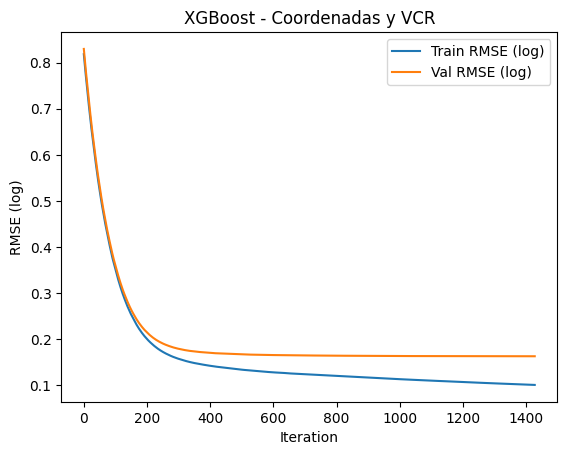

In [46]:
plt.figure()
plt.plot(rmse_log_train, label="Train RMSE (log)")
plt.plot(rmse_log_val, label="Val RMSE (log)")
plt.xlabel("Iteration"); plt.ylabel("RMSE (log)")
plt.title("XGBoost - Coordenadas y VCR")
plt.legend(); plt.show()

In [47]:
# --- Predicciones en LOG ---
y_pred_train_log = model.predict(X_train)
y_pred_val_log   = model.predict(X_val)
y_pred_test_log  = model.predict(X_test)

# --- Métricas en LOG ---
def rmse_log(y_true_log, y_pred_log):
    return float(np.sqrt(np.mean((y_true_log - y_pred_log) ** 2)))

r2_log_train   = r2_score(y_train, y_pred_train_log)
r2_log_val     = r2_score(y_val,   y_pred_val_log)
r2_log_test    = r2_score(y_test,  y_pred_test_log)

rmse_log_train = rmse_log(y_train, y_pred_train_log)
rmse_log_val   = rmse_log(y_val,   y_pred_val_log)
rmse_log_test  = rmse_log(y_test,  y_pred_test_log)

mae_log_train  = mean_absolute_error(y_train, y_pred_train_log)
mae_log_val    = mean_absolute_error(y_val,   y_pred_val_log)
mae_log_test   = mean_absolute_error(y_test,  y_pred_test_log)

# --- Métricas en UF (precio) ---
y_true_train_price = DF.loc[X_train.index, "monto"].to_numpy(dtype=float)
y_true_val_price   = DF.loc[X_val.index,   "monto"].to_numpy(dtype=float)
y_true_test_price  = DF.loc[X_test.index,  "monto"].to_numpy(dtype=float)

y_pred_train_price = np.exp(y_pred_train_log)
y_pred_val_price   = np.exp(y_pred_val_log)
y_pred_test_price  = np.exp(y_pred_test_log)

rmse_train = root_mean_squared_error(y_true_train_price, y_pred_train_price)
rmse_val   = root_mean_squared_error(y_true_val_price,   y_pred_val_price)
rmse_test  = root_mean_squared_error(y_true_test_price,  y_pred_test_price)

mae_train  = mean_absolute_error(y_true_train_price, y_pred_train_price)
mae_val    = mean_absolute_error(y_true_val_price,   y_pred_val_price)
mae_test   = mean_absolute_error(y_true_test_price,  y_pred_test_price)

mape_train = np.mean(np.abs((y_true_train_price - y_pred_train_price) / np.clip(y_true_train_price, 1e-9, None))) * 100
mape_val   = np.mean(np.abs((y_true_val_price   - y_pred_val_price)   / np.clip(y_true_val_price,   1e-9, None))) * 100
mape_test  = np.mean(np.abs((y_true_test_price  - y_pred_test_price)  / np.clip(y_true_test_price,  1e-9, None))) * 100

print("=== XGBoost (log_monto) ===")
print(">> LOG space")
print(f"Train: R^2={r2_log_train:.4f} | RMSE_log={rmse_log_train:.4f} | MAE_log={mae_log_train:.4f}")
print(f"Val  : R^2={r2_log_val:.4f}   | RMSE_log={rmse_log_val:.4f}   | MAE_log={mae_log_val:.4f}")
print(f"Test : R^2={r2_log_test:.4f}  | RMSE_log={rmse_log_test:.4f}  | MAE_log={mae_log_test:.4f}")

print(">> UF space (precio)")
print(f"Train: RMSE={rmse_train:,.2f} | MAE={mae_train:,.2f} | MAPE={mape_train:.2f}%")
print(f"Val  : RMSE={rmse_val:,.2f}   | MAE={mae_val:,.2f}   | MAPE={mape_val:.2f}%")
print(f"Test : RMSE={rmse_test:,.2f}  | MAE={mae_test:,.2f}  | MAPE={mape_test:.2f}%")


# %% Importancias (gain)
booster = model.get_booster()
score = booster.get_score(importance_type="gain")
if score:
    imp = (
        pd.Series(score)
        .rename("gain")
        .sort_values(ascending=False)
        .to_frame()
        )
print("\nTop 20 features por gain:")
print(imp.head(20).to_string())

=== XGBoost (log_monto) ===
>> LOG space
Train: R^2=0.9852 | RMSE_log=0.1006 | MAE_log=0.0735
Val  : R^2=0.9622   | RMSE_log=0.1628   | MAE_log=0.1145
Test : R^2=0.9641  | RMSE_log=0.1587  | MAE_log=0.1155
>> UF space (precio)
Train: RMSE=896.42 | MAE=440.79 | MAPE=7.38%
Val  : RMSE=1,480.39   | MAE=719.23   | MAPE=11.82%
Test : RMSE=1,503.62  | MAE=711.13  | MAPE=11.72%

Top 20 features por gain:
                              gain
superficie_t             51.762352
banos                    37.110897
longitud                 35.579689
latitud                   8.388224
estacionamiento           8.242074
terraza                   5.355755
sport_and_leisure_dim00   4.753791
dormitorios               3.877417
sport_and_leisure_dim03   3.649190
education_sup_dim00       3.230587
security_dim00            2.355186
education_prim_dim09      2.350250
sport_and_leisure_dim10   2.051032
education_prim_dim10      1.966797
education_sup_dim10       1.873962
sport_and_leisure_dim08   1.695246
educ

#### Resultados XGBoost (sin optimizacion de hiperparametros)

| Modelo                        | Conjunto | R² (log) | RMSE_log | MAE_log | RMSE ($) | MAE ($) | MAPE (%) |
|-------------------------------|----------|:--------:|---------:|--------:|---------:|--------:|---------:|
| **1) XGBoost (solo estructural)** | Train    | 0.9277   |   0.2222 |   0.1652 |  1,649.99 |   930.96 |   17.03 |
|                               | Val      | 0.9133   |   0.2466 |   0.1843 |  2,038.48 | 1,112.79 |   19.22 |
|                               | Test     | 0.9128   |   0.2474 |   0.1847 |  1,922.45 | 1,063.77 |   19.23 |
| **2) XGBoost + lat/lon**      | Train    | 0.9798   |   0.1175 |   0.0857 |  1,011.66 |   510.00 |    8.63 |
|                               | Val      | 0.9602   |   0.1671 |   0.1191 |  1,528.85 |   746.13 |   12.30 |
|                               | Test     | 0.9627   |   0.1619 |   0.1191 |  1,465.62 |   720.77 |   12.08 |
| **3) XGBoost + lat/lon + VCR**| Train    | 0.9848   |   0.1019 |   0.0758 |    910.41 |   459.46 |    7.61 |
|                               | Val      | 0.9613   |   0.1648 |   0.1157 |  1,498.16 |   731.39 |   11.95 |
|                               | Test     | 0.9633   |   0.1604 |   0.1170 |  1,533.91 |   722.69 |   11.86 |


En el caso de XGBoost, los resultados evidencian un desempeño muy competitivo desde el modelo de control. Con solo las variables estructurales, ya se obtiene un R² logarítmico de 0.91 y un MAPE cercano al 19.2%, lo que representa un salto importante respecto a los modelos lineales. La incorporación de las coordenadas de latitud y longitud aporta una mejora sustancial: el R² asciende a 0.96, y tanto los errores absolutos como relativos disminuyen de manera considerable (RMSE = 1,466; MAE = 721; MAPE = 12.1%). Sin embargo, al incluir los vectores de características de referencia (VCR), la ganancia adicional es marginal: el R² apenas se incrementa de 0.9627 a 0.9633, mientras que RMSE y MAE empeoran ligeramente en el conjunto de prueba. Solo el MAPE muestra una mejora (de 12.1% a 11.9%), lo que sugiere que el modelo con VCR ajusta mejor los segmentos de precios típicos —donde existe mayor densidad de datos— pero pierde precisión en los extremos superiores del mercado, donde el efecto de la asimetría es más pronunciado. Este comportamiento se explica porque, al exponenciar las predicciones para calcular errores en UF, las desviaciones en propiedades muy caras pesan de forma desproporcionada en métricas como RMSE y MAE, mientras que el MAPE pondera los errores de manera relativa. En síntesis, los VCR implican un gran esfuerzo de ingeniería y procesamiento, pero su impacto en XGBoost resulta marginal frente a la enorme mejora que ya ofrecen las coordenadas básicas.

#### Resultados XGBoost (con optimización de hiperparámetros)

| Modelo                         | Conjunto | R² (log) | RMSE_log | MAE_log | RMSE ($) | MAE ($) | MAPE (%) |
|--------------------------------|----------|:--------:|:--------:|:-------:|---------:|--------:|---------:|
| **1) XGBoost (solo estructural)** | Train    | 0.9246   | 0.2268   | 0.1688  | 1,758.74 |   968.72 | 17.41 |
|                                | Val      | 0.9134   | 0.2465   | 0.1834  | 2,028.34 | 1,105.52 | 19.14 |
|                                | **Test** |**0.9127**|**0.2476**|**0.1851**|**1,931.58**|**1,068.16**|**19.25**|
| **2) XGBoost + lat/lon**       | Train    | 0.9781   | 0.1222   | 0.0893  | 1,064.62 |   534.16 |  9.00 |
|                                | Val      | 0.9602   | 0.1671   | 0.1188  | 1,530.47 |   742.42 | 12.29 |
|                                | **Test** |**0.9625**|**0.1622**|**0.1193**|**1,488.08**|**727.06**|**12.10**|
| **3) XGBoost + lat/lon + VCR** | Train    | 0.9852   | 0.1006   | 0.0735  |   896.42 |   440.79 |  7.38 |
|                                | Val      | 0.9622   | 0.1628   | 0.1145  | 1,480.39 |   719.23 | 11.82 |
|                                |**Test**|**0.9641**|**0.1587**|**0.1155**|**1,503.62**|**711.13**|**11.72**|
